In [17]:
! pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch

  Cloning https://github.com/jlcsilva/segmentation_models.pytorch to /tmp/pip-req-build-w9oao0um
  Running command git clone --filter=blob:none --quiet https://github.com/jlcsilva/segmentation_models.pytorch /tmp/pip-req-build-w9oao0um
  Resolved https://github.com/jlcsilva/segmentation_models.pytorch to commit 44a5593bfb1c8f2a3f5f23303c02e6f7e2f11170
  Preparing metadata (setup.py) ... done


In [18]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class RunwayDataset(Dataset):
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
    # Read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_fps[i], 0)

      # --- FIX: ALWAYS RESIZE FIRST ---
      # This ensures both image and mask are the correct size before anything else.
      resizer = A.Resize(height=256, width=256, always_apply=True)
      resized_sample = resizer(image=image, mask=mask)
      image = resized_sample['image']
      mask = resized_sample['mask']

      # Apply other random augmentations on the resized sample
      if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']

      # Apply preprocessing (normalization and tensor conversion)
      if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']

      #  Transpose the image from (H, W, C) to (C, H, W)
      image = image.transpose(2, 0, 1)

      image_tensor = torch.from_numpy(image).float()
      mask_tensor = torch.from_numpy(mask).float()

      # 3. Add the channel dimension to the mask
      mask_tensor = mask_tensor.unsqueeze(0)


      return image_tensor, mask_tensor

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch as torch
import segmentation_models_pytorch as smp
import albumentations as A
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

# Define augmentations
#implemented Stronger augmentations
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5), # Add vertical flips
    A.Affine(
        scale=(0.8, 1.2), # Zoom in/out more
        translate_percent=(-0.2, 0.2), # Shift more
        rotate=(-45, 45), # Rotate more
        p=0.75 # Apply this more often
    ),
    A.RandomBrightnessContrast(p=0.5), # Change lighting
    A.GaussNoise(p=0.3), # Add some noise
])

# Define preprocessing
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
preprocess_input = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

preprocessing_fn = A.Compose([
    A.Lambda(image=preprocess_input),

])


DATA_DIR_IMG = '/content/drive/MyDrive/Dataset/1920x1080/1920x1080'
DATA_DIR_Mask = '/content/drive/MyDrive/Dataset/labels/labels/areas'
# Create instances of the dataset for training and validation
train_dataset = RunwayDataset(
    os.path.join(DATA_DIR_IMG, 'train'),
    os.path.join(DATA_DIR_Mask, 'train_labels_1920x1080'),
    augmentation=train_transform,
    preprocessing=preprocessing_fn,
)

# Create the data loader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
if __name__ == '__main__':
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = smp.Unet(
        encoder_name='efficientnet-b4',#Efficientnet is better than resnet34.efficientnet-b5 is even better but heavier
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation='sigmoid',
    )
    model.to(DEVICE)
    loss_fn = smp.losses.DiceLoss(mode='binary')
    #loss_fn = smp.losses.DiceLoss(mode='binary') + smp.losses.FocalLoss(mode='binary')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #lr=0.0005 more better most of times or it may as well increase
    # may as well use Learning Rate Scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau
    def slice_through_data_and_train(model, loader, optimizer, loss_fn, device):
        model.train()
        running_loss = 0.0
        for epochs in range(50):#50 or 100
          for images, masks in loader:

              images = images.to(device)
              masks = masks.to(device)


              optimizer.zero_grad()


              predictions = model(images)


              loss = loss_fn(predictions, masks)


              loss.backward()


              optimizer.step()

              running_loss += loss.item() * images.size(0)

              epoch_loss = running_loss / len(loader.dataset)
        return epoch_loss
    epoch_loss = slice_through_data_and_train(model, train_loader, optimizer, loss_fn, DEVICE)
    print(f"Epoch Loss: {epoch_loss:.4f}")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


100%|██████████| 74.4M/74.4M [00:02<00:00, 34.8MB/s]
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_ap

# **For seeing the images which are created**

In [29]:
#loades a set of image and masks
images, masks = next(iter(train_loader))

/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)
/tmp/ipython-input-2468550271.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resizer = A.Resize(height=256, width=256, always_apply=True)


In [30]:
model.eval()  #evalute the model
with torch.no_grad():

    images = images.to(DEVICE)

    # Probability mask
    predicted_masks = model(images)


predicted_masks = (predicted_masks > 0.5).float()


images = images.cpu()
masks = masks.cpu()
predicted_masks = predicted_masks.cpu()

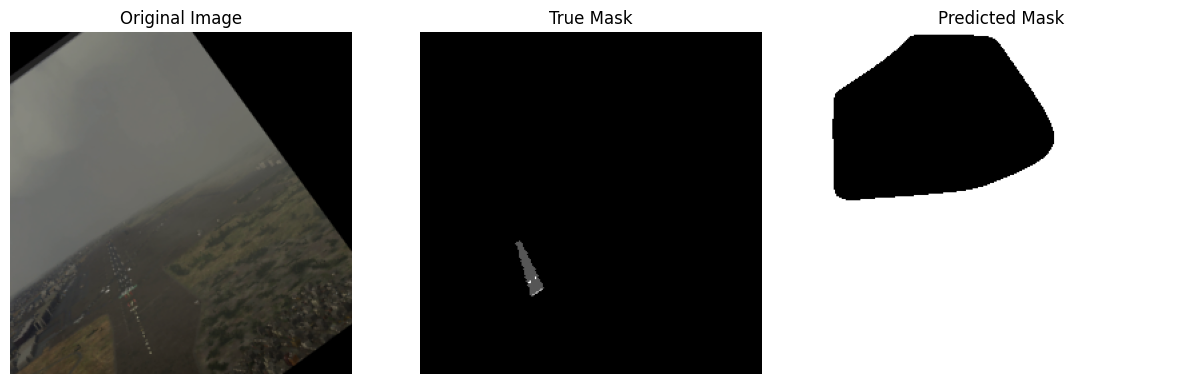

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(image, ground_truth_mask, predicted_mask):
    """Plots original image, true mask, and predicted mask."""

    #converts to orignal format of codes of images
    image = image.numpy().transpose(1, 2, 0)


    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Squeeze the channel dimension for the masks
    ground_truth_mask = ground_truth_mask.squeeze()
    predicted_mask = predicted_mask.squeeze()

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize the first image in the batch
visualize(
    image=images[0],
    ground_truth_mask=masks[0],
    predicted_mask=predicted_masks[0]
)

# **To find Optimum Epochs and Store the best model in best_model.pth file**
This file would contain the best model parameters which showed minimum testing data error.Next time we can simply load that best model

In [24]:
import torch

# Assume train_loader and valid_loader are created

num_epochs = 50
best_valid_loss = float('inf') # Initialize with a very high number

for epoch in range(num_epochs):
    # Run one epoch of training
    train_loss = train_loader(model, train_loader, optimizer, loss_fn, DEVICE)

    # Run one epoch of validation
    # create validate loader using the test data
    valid_loss = validate_loader(model, validadate_loader, loss_fn, DEVICE)

    # Check if this is the best model so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved! New best validation loss: {best_valid_loss:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

print("Training finished!")